In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt

from tools.ResampleTools import resample_interp
from tools.NormalizeTools import normalize_sig_hist
from tools.SimpleFilter import smooth_avg1
from tools.QRSDetector import simple_qrs_detector
from tools.HRVS import hrvs
from tools.SingleBeatBounds import dwt_ecg_delineator
from features.ECGAvgBeat import extract_avg_wave
from features.ECGAvgBeat import extract_features

In [2]:
with open('data/example_data.txt', 'r') as fr:
    raw_data = json.load(fr)

ecg_signal = raw_data  # raw_datat-->list or array
# ecg_signal = np.array(ecg_signal)

fs_raw = 125   # 原始采样率
fs_out = 500  # 重采样率

# ECG信号重采样--基于线性拟合的差值重采样算法
resample_ecg = resample_interp(ecg_signal, fs_raw, fs_out)

# 滤波--均值滤波
filter_ecg = smooth_avg1(resample_ecg, radius=3)

# 数据归一化--按信号的直方图百分比进行数据归一化
ecg_data = normalize_sig_hist(filter_ecg, TH=0.01)

# QRS波的位置检测-->R波波峰位置
qrs = simple_qrs_detector(ecg_data, fs_out)

# 心率变异性HRV-->FrequencyDomain频域, TimeDomain时域, NonLinear非线性
hrv = hrvs(peaks=qrs, fs=fs_out)

# 平均波形提取-->平均波形及平均波形的R波位置
avg_wave, r, avg_rr = extract_avg_wave(ecg_data, qrs, fs_out)

# 单个Beat的各波定位-->P波、T波起始及峰值位置/QRS波起始位置/Q波和S波峰值位置
bound_infos = dwt_ecg_delineator(avg_wave, r, fs_out)

p = bound_infos['ECG_P_Peak']  # p波峰值位置
p_start = bound_infos['ECG_P_Onset']  # p波开始位置
p_end = bound_infos['ECG_P_Offset']  # p波结束位置
q = bound_infos['ECG_Q_Peak']  # q波峰值位置
s = bound_infos['ECG_S_Peak']  # s波峰值位置
qrs_start = bound_infos['ECG_R_Onset']  # qrs波开始位置
qrs_end = bound_infos['ECG_R_Offset']  # qrs波结束位置
t = bound_infos['ECG_T_Peak']  # t波峰值位置
t_start = bound_infos['ECG_T_Onset']  # t波开始位置
t_end = bound_infos['ECG_T_Offset']  # t波结束位置

#  特征提取-->QRS波/PR段/ST段/T波/P波等特征信息
features = extract_features(avg_wave, p_start, p_end, qrs_start, qrs_end, t_start, t_end, fs_out, avg_rr)


In [3]:
features

{'QT': 282,
 'QTc': 434,
 'HR': 142,
 'R/T': 5.714285714285714,
 'QRS': {'RAmplitude': 0.76,
  'SAmplitude': nan,
  'QAmplitude': 0.272,
  "R'Amplitude": nan,
  'RDuration': 52,
  'SDuration': nan,
  'QDuration': 27,
  "R'Duration": nan,
  'QRSPrinciple': '+',
  'QRSAmplitude': 1.032,
  'QRSDuration': 80,
  'Q/R': 0.35789473684210527},
 'PR': {'computable': True, 'interval': 126, 'form': 'horizontal'},
 'ST': {'computable': True,
  'duration': 232,
  'form': 'upslope',
  'amplitude': 0.21400000000000002},
 'T': {'exist': True,
  'form': '+',
  'amplitude': 0.133,
  'direction': '+',
  'duration': 282},
 'P': {'exist': True,
  'form': '+',
  'amplitude': 0.04000000000000001,
  'direction': '+',
  'duration': 64}}

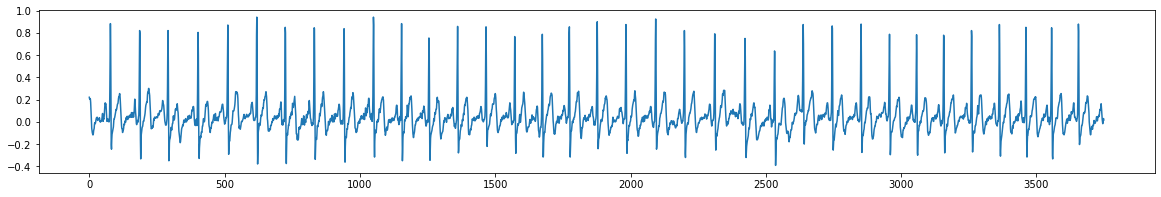

In [4]:
plt.figure(figsize=(20,3))
plt.plot(ecg_signal)

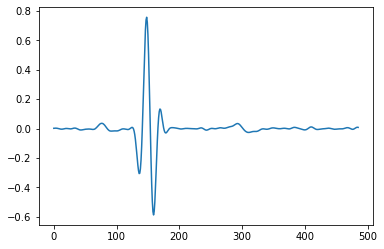

In [5]:
plt.plot(avg_wave)